In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34387")

# Import

In [6]:
import sys
sys.path.insert(1, '..')

In [7]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

# Plotting params

In [8]:
#%matplotlib widget
%matplotlib inline

In [9]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [10]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# Useful functions for histograms

In [11]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=bins1, weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [12]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(np.abs(dataSet[var1]).min(), np.abs(dataSet[var1]).max(), nb_of_bins)
        bins2 = np.linspace(np.abs(dataSet[var2]).min(), np.abs(dataSet[var2]).max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(np.abs(dataSet[var1].fillna(0)), np.abs(dataSet[var2].fillna(0)), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

## Plotting

In [13]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='linear', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='linear', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [14]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [15]:
nb_of_bins = 150

## Distance between histograms

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [16]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-np.around(BC(hist_P,hist_Q), decimals=5))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return np.NaN

Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [171]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [172]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

# Load data

Choose cases

In [17]:
data=[dict() for i in range(6)]

In [18]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

## eNATL60

In [19]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [20]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,150),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [21]:
nb_of_time_chunks = 4

In [22]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 2.99 s, sys: 567 ms, total: 3.55 s
Wall time: 1min 20s


## eORCA025

In [23]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'

## Plot snapshots

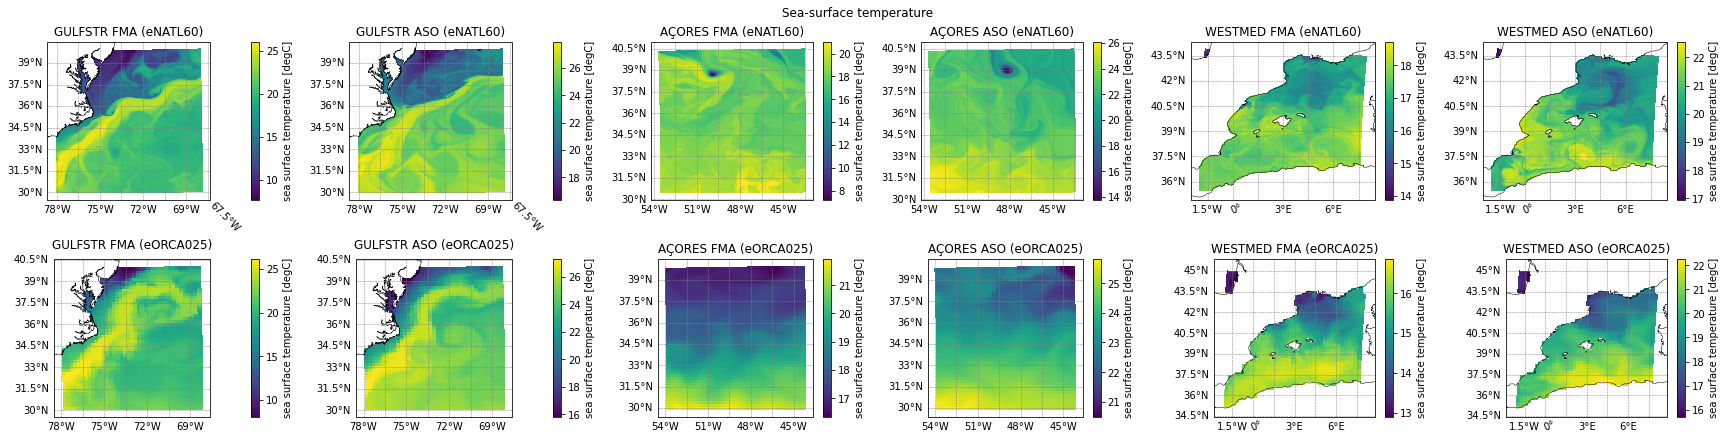

In [24]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
fig.suptitle('Sea-surface temperature')
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=data[col]['label'] + ' ('+data[col][dataSetKey].attrs['source']+')')

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# "True" density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library. Is computed before filtering.

In [25]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 1.02 s, sys: 622 ms, total: 1.64 s
Wall time: 3.48 s


# Filters

## Routines

In [26]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    threshold = 0.0
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    #apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [27]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [28]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.25° + Coarse to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 2*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 0.5° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 1° + Interp to 0.25°'})]

In [29]:
regrid_method = 'bilinear'

In [30]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 1min 9s, sys: 31 s, total: 1min 40s
Wall time: 3min 31s


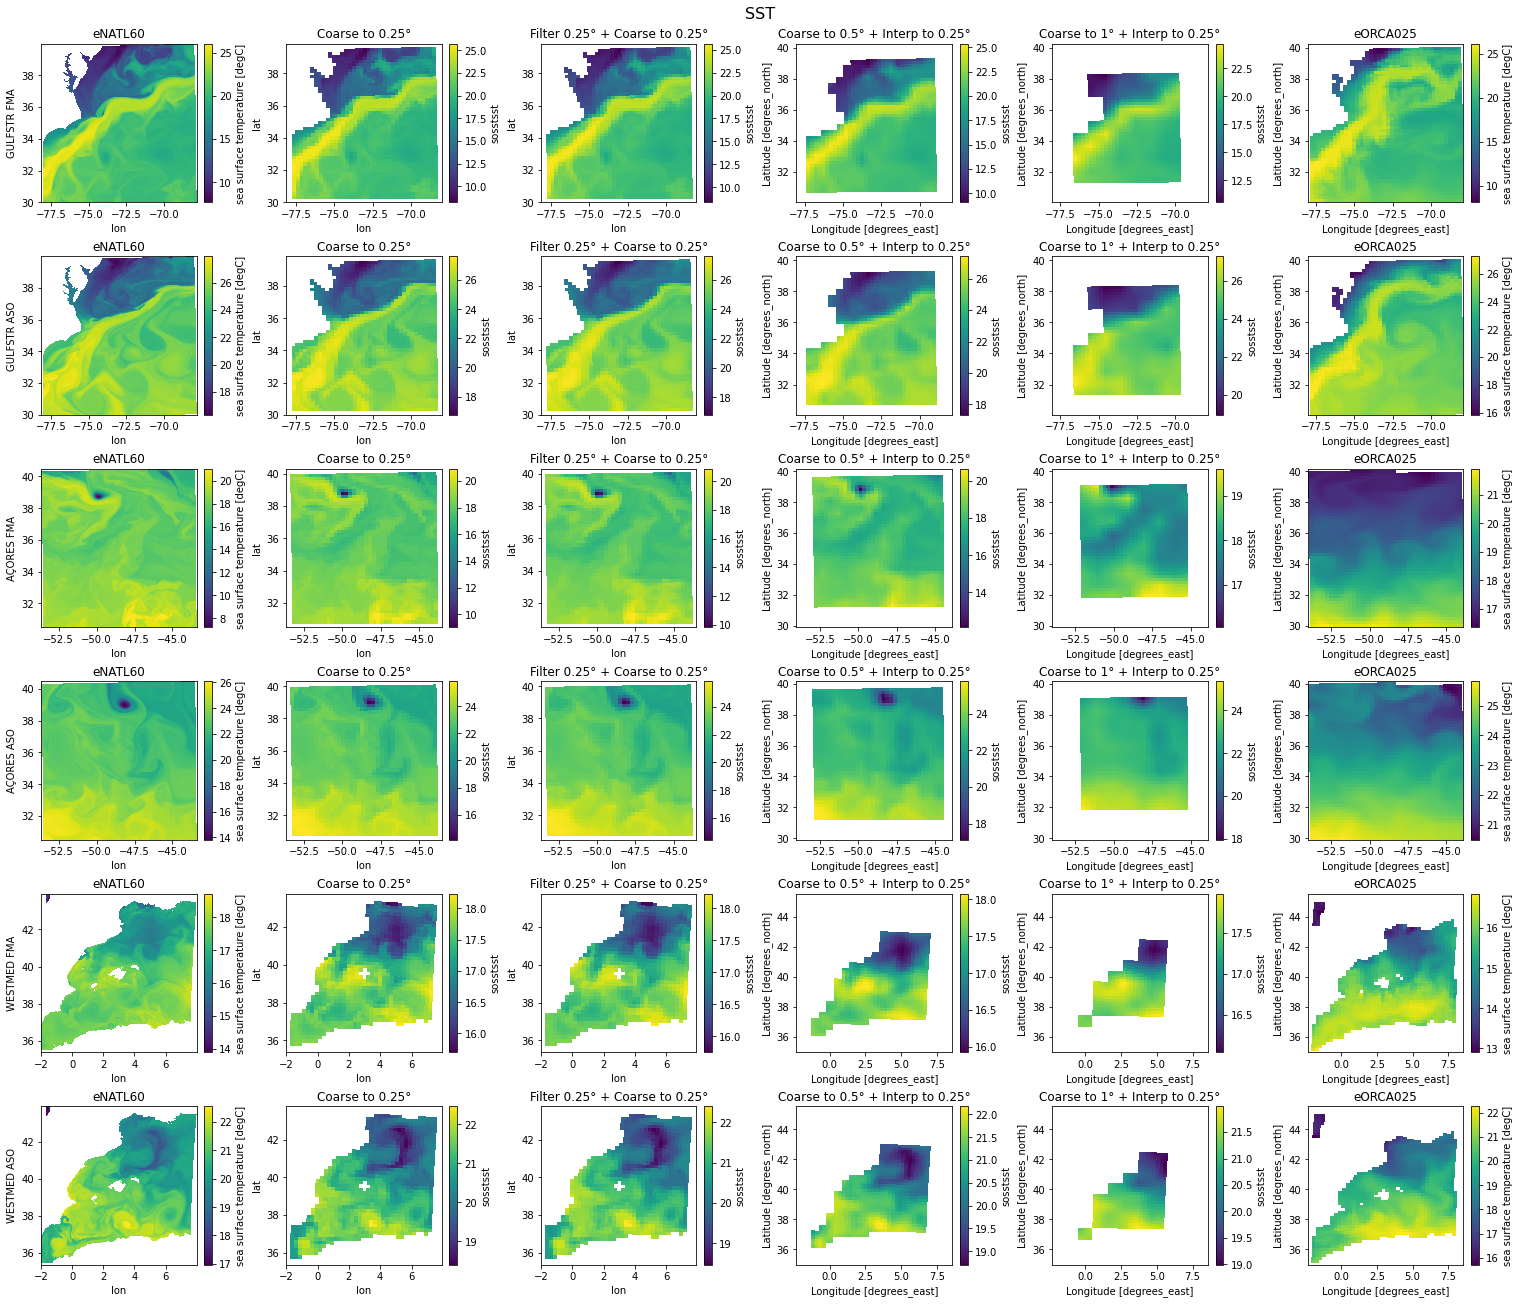

In [31]:
ncols = len(filters)+2 
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Compute the subgrid variance and density error

Subgrid variance for temperature and salinity is computed as:
$$ \sigma_T^2 = \overline{T^2} -  \overline{T}^2 $$
$$ \sigma_S^2 = \overline{S^2} - \overline{S}^2 $$

The density error is computed as differene between the density obtained by filtering the HR density and the one evaluated on the basis of filtered temperature and salinity:
$$ \Delta \rho =  \overline{\rho(T,S)} - \rho(\overline{T}, \overline{S}) $$

In [32]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        # subgrid temp variance
        ds['var_T'] = ds['sst_sqr'] - ds['sosstsst']**2
        ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
        # density correction
        ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
        ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 1.02 s, sys: 45.6 ms, total: 1.06 s
Wall time: 2 s


Compute the second derivatives of the density with the respect to temperature and salinity (known from the EOS)

In [33]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['sosstsst'])

CPU times: user 16.7 s, sys: 30.4 ms, total: 16.8 s
Wall time: 16.8 s


## Plots of true subgrid temperature variance

In [34]:
x_slice = slice(1,-1)
y_slice = slice(1,-1)
bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

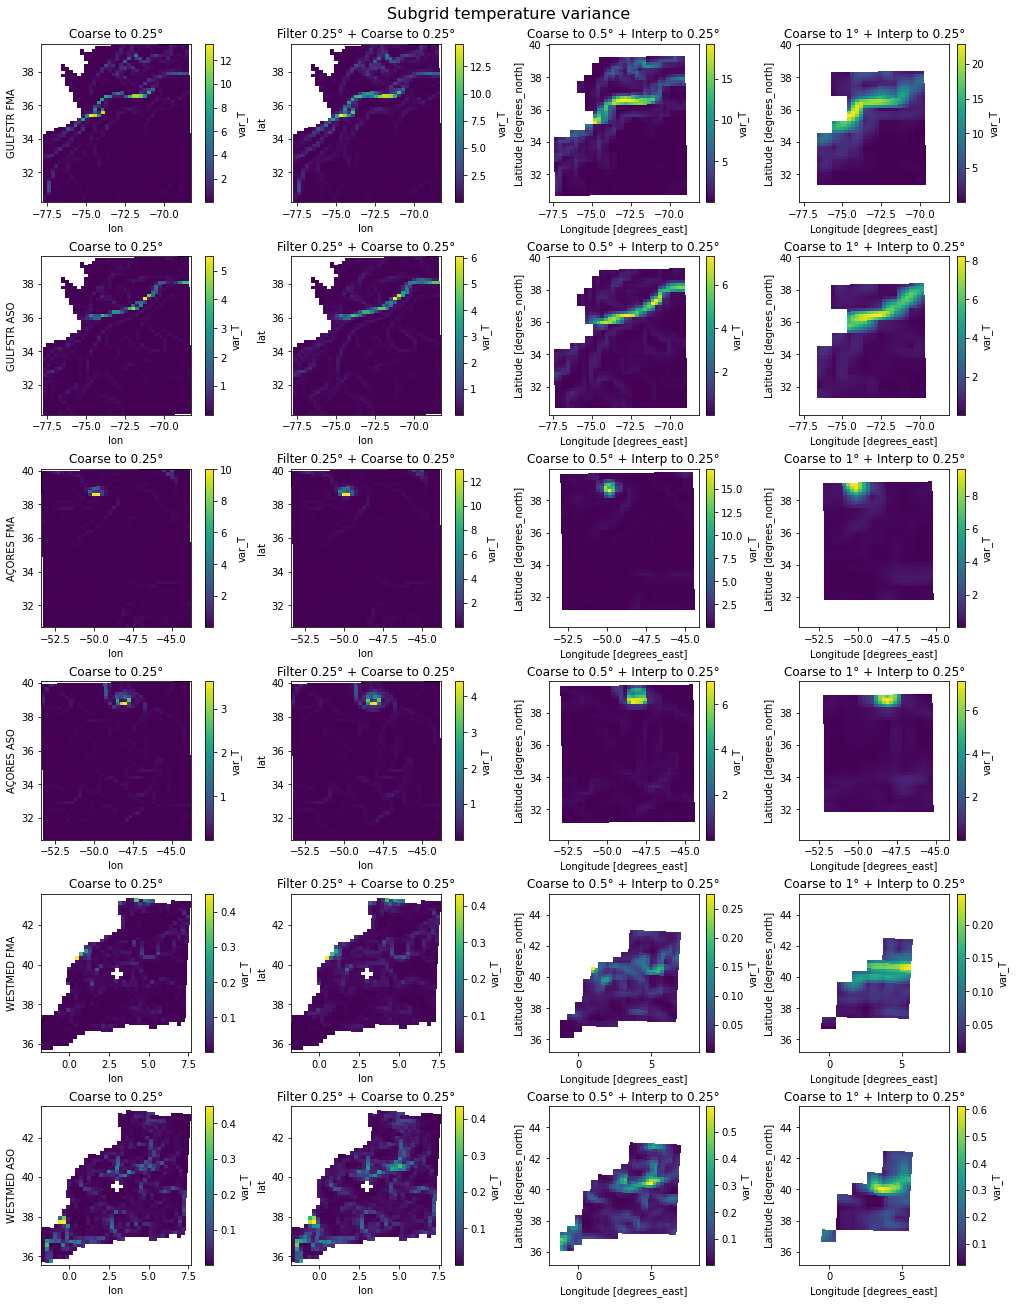

In [35]:
ncols = len(filters)
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='var_T'
fig.suptitle('Subgrid temperature variance', size=16)
for row in range(len(data)) :
    for ifilter in range(len(filters)) :
        col = ifilter
        var = data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity]
        (var.where(var>0))[bord_cut].plot(x='lon', y='lat', ax=axis[row,col], cmap='viridis')
        axis[row,col].set(title=filters[ifilter]['label'])   
    axis[row,0].set(ylabel=data[row]['label'])

In [36]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

# Deterministic parametrization for the density error

From (Stanley et al 2021), the density correction is determined mainly by the temperature subgrid variance $\sigma^2_T$ and the local second derivative of the density with the respect to temperature (known from the EOS) evaluated on the basis of filtered fields. 
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 $$
It is assumed that the most important contribution comes from the temperature variance term:
$$ \rho_c \approx \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
It is proposed to estimate the temperature and salinity subgrid variance with local gradient (computed numerically through finite differences):
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$. The values found from fitting of the data is $c=0.2$.

# 1st assumption: link between the "true" density error and the "true" subgrid variance of temperature/salinity 

Here, we will try to test the first assumption in the parametrization: the link between the density error and the true subgrid variance.
In particular, we will consider the expression including the "total" variance (of temperature, salinity and the mixed one):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 $$
and the approximate simplified expression with the "only-temperature" variance (as the temperature contributes the most):
$$ \rho_c \approx \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2  $$
For this purpose, the spatial covariance between 2D maps of the r.h.s. of expressions above and the "true" desity error is computed. Note that ar this point the "true" subgrid variances of temperature and salinity are used (they are not parametrized yet). </br>
Another way to establish statistical link between the density error and the subgrid varinca is to check the 2D histograms, where one variable is the true density error $\rho_c$ and another variable is the r.h.s. of the expressions above. The histograms are then fitted linearly.

In [37]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))]:
        ds["var_T_dens_deriv"] = 0.5*ds['rho_ct_ct']*ds["var_T"]
        ds["var_S_dens_deriv"] = 0.5*ds['rho_sa_sa']*ds["var_S"]
        ds["var_TS_dens_deriv"] = ds['rho_sa_ct']*np.sqrt(ds["var_S"])*np.sqrt(ds["var_T"])
        ds["total_var_dens_deriv"] = ds["var_T_dens_deriv"] + ds["var_TS_dens_deriv"] + ds["var_S_dens_deriv"]

CPU times: user 740 ms, sys: 3.15 ms, total: 744 ms
Wall time: 742 ms


## Contribution of each term (in average)

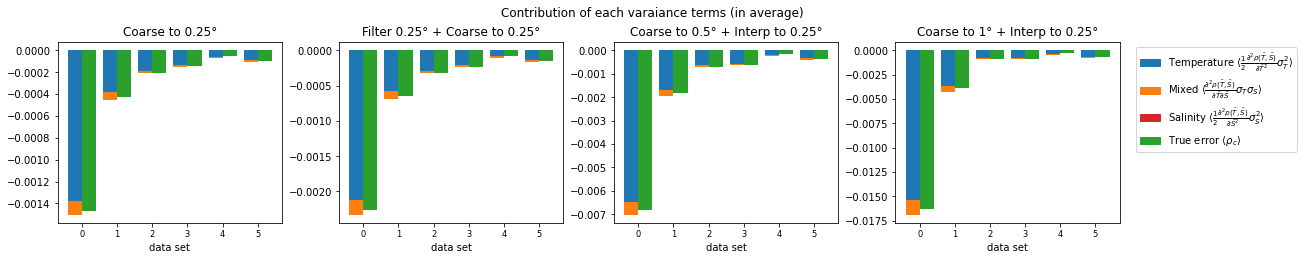

CPU times: user 5.82 s, sys: 331 ms, total: 6.15 s
Wall time: 14.7 s


In [38]:
%%time
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(18, 3.5), sharey=False)
fig.suptitle(r'Contribution of each varaiance terms (in average)')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for i in range(len(data)) :
        ds = data[i]['HR_Filtered'][ifilter]
        bar1 = ds['var_T_dens_deriv'].mean().compute()
        bar2 = ds['var_TS_dens_deriv'].mean().compute()
        bar3 = ds['var_S_dens_deriv'].mean().compute()
        ax[ifilter].bar(x[i], bar1, width=bar_width, color=line_colors[0])
        ax[ifilter].bar(x[i], bar2, bottom=bar1, width=bar_width, color=line_colors[1])
        ax[ifilter].bar(x[i], bar3, width=bar_width, color=line_colors[3])
        ax[ifilter].bar(x[i]+bar_width, ds['sigma0_delta'].mean(), width=bar_width, color=line_colors[2])
    ax[ifilter].set(title=filters[ifilter]['label'])
patches = [None]*4
patches[0] = mpatches.Patch(color=line_colors[0], label=r'Temperature $\langle \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 \rangle$')
patches[1] = mpatches.Patch(color=line_colors[1], label=r'Mixed $\langle \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S \rangle$')
patches[2] = mpatches.Patch(color=line_colors[3], label=r'Salinity $\langle \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 \rangle$')
patches[3] = mpatches.Patch(color=line_colors[2], label=r'True error $\langle \rho_c \rangle$')
ax[-1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    #axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xlabel('data set')
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

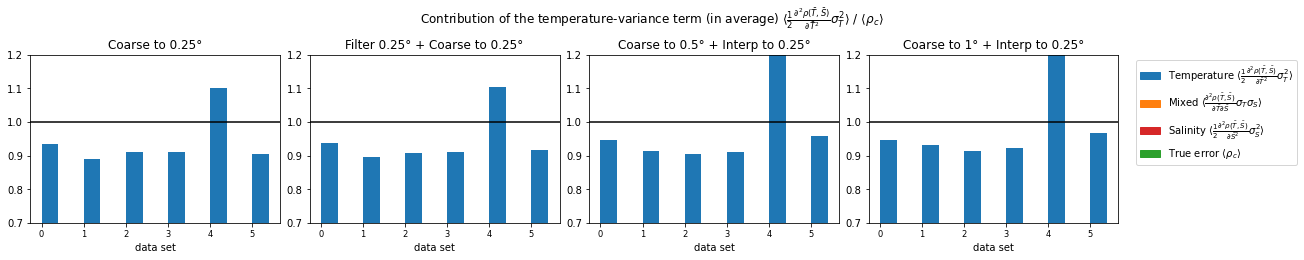

CPU times: user 2 s, sys: 291 ms, total: 2.29 s
Wall time: 4.22 s


In [39]:
%%time
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(18, 3.5), sharey=False)
fig.suptitle(r'Contribution of the temperature-variance term (in average) $\langle \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 \rangle~/~\langle\rho_c \rangle$')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for i in range(len(data)) :
        ds = data[i]['HR_Filtered'][ifilter]
        bar1 = (ds['var_T_dens_deriv']).mean().compute()/ds['sigma0_delta'].mean().compute()
        ax[ifilter].bar(x[i]+bar_width, bar1, width=bar_width, color=line_colors[0])
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.set_ylim(0.7,1.2)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xlabel('data set')
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

Observations:
- In average (in space and time), the approximation of the density error by the second-order Taylor expansion with in terms of the subgrid variance of temperature and salinity works quite accurate.
- The temperature varince term gives the most contribution to the density error (more than 90% in most of cases). It is followed by the contribution of the mixed-variance term (around 10%). The contribution of the salinity-variance term is of order ~1%, and has an opposite sign to the temperature-variance term (due to curvature of the EOS).

## Spatial covariance between the density error and the true subgrid variance

In [40]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_T'] = xr.corr(data[i]['HR_Filtered'][ifilter]['var_T_dens_deriv'], data[i]['HR_Filtered'][ifilter]['sigma0_delta'], \
                                                                          dim=['x', 'y']).compute()
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_total'] = xr.corr(data[i]['HR_Filtered'][ifilter]['total_var_dens_deriv'], data[i]['HR_Filtered'][ifilter]['sigma0_delta'], \
                                                                          dim=['x', 'y']).compute()

CPU times: user 9.97 s, sys: 170 ms, total: 10.1 s
Wall time: 19.5 s


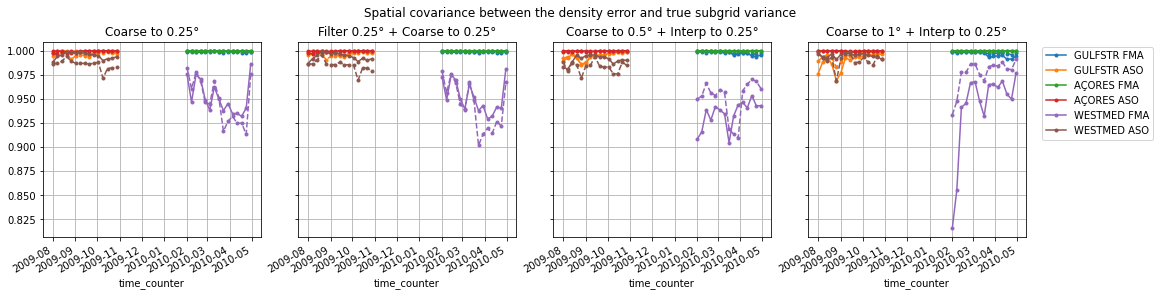

In [41]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between the density error and true subgrid variance')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_total'].plot(ax=ax[ifilter], ls='-', marker='.', color=line_colors[i], label=data[i]['label'])
        hists[i]['HR_Filtered'][ifilter]['corr_error_vs_var_T'].plot(ax=ax[ifilter], ls='--', marker='.', color=line_colors[i])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

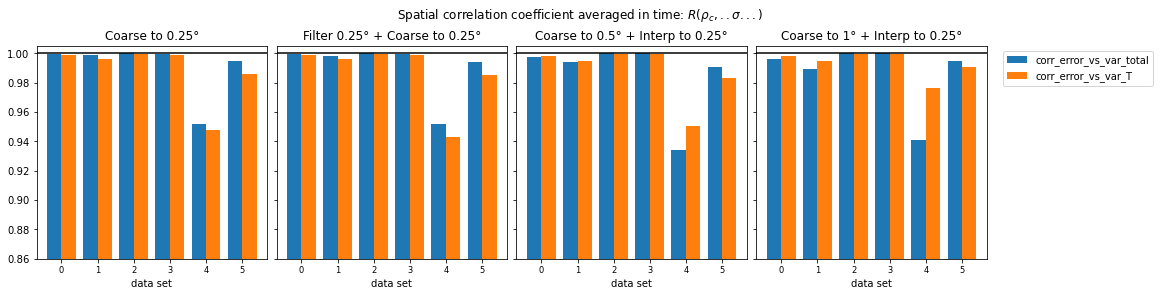

In [42]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, ..\sigma...)$')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['corr_error_vs_var_total', 'corr_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [(hists[region]['HR_Filtered'][ifilter][quantity].mean()) for region in range(len(data))], \
                        width=bar_width, label=quantity)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear', ylim=[0.86,1.005])
plt.show()

- The plots for spatial covariance between the density error and the temperature/salinity subgrid variance demostrate that these quantites are strongly correlated in space. 
- If the high-resolution fields are coarsed to the resolution 0.25deg (first two plots), the expression for the 'total' subgrid variance (including both tempreature and salinity, as well as theit mixed variance) gives slightly better correlation coefficient (the blue plots bars are lower), comparing to the purely temperature-variance expression (orange plot bars).
- Coarsening to lower resolutions (0.5deg, 1deg) leads to a reduction of the correlation coefficient in general
- From this analysis, it appears that when coarsening or filtering+coarsening to 0.25deg is applied to the data, the locations with strong subgrid variance of temperature and salinity almost coincide with the locations with density error, meaning that this parametrization is expected to provide correct result. 

## 2D histograms of density error and subgrid variance

$$ H \left(\rho_c, \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 + \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} \sigma_T \sigma_S +  \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} \sigma_S^2 \right) $$

### "Total" variance (temperature+salinity+mixed)

In [43]:
%%time
name_hist = 'hist_error_vs_var_total'
x = 'total_var_dens_deriv'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 5.58 s, sys: 90.9 ms, total: 5.67 s
Wall time: 10.5 s


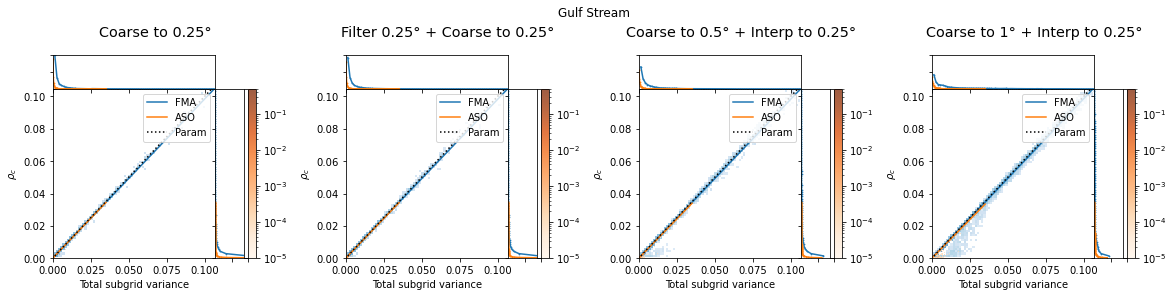

In [44]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_error_vs_var_total'
x = 'total_var_dens_deriv'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 1.*x_points, 'k:', label='Param')
    big_ax.set(xlabel=r'Total subgrid variance', ylabel=r'$\rho_c$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

### Only-temperature variance

$$ H \left(\rho_c, \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 \right) $$

In [45]:
%%time
name_hist = 'hist_error_vs_var_T'
x = 'var_T_dens_deriv'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 3.95 s, sys: 90.1 ms, total: 4.04 s
Wall time: 8.29 s


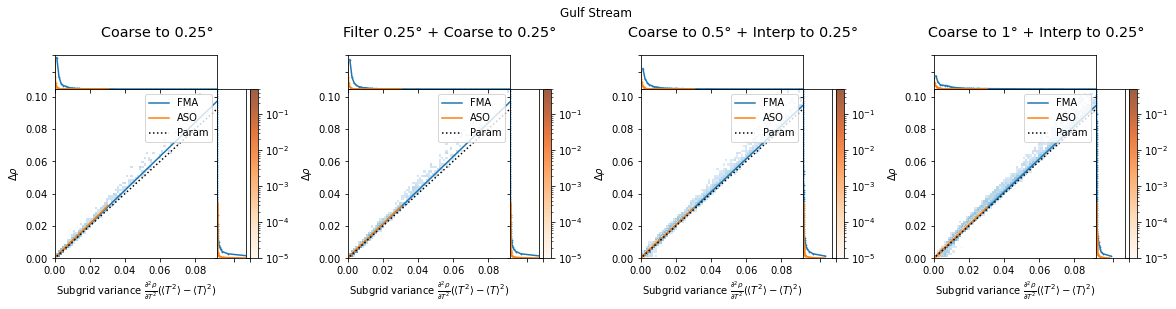

In [46]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_error_vs_var_T'
x = 'var_T_dens_deriv'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 1.*x_points, 'k:', label='Param')
    big_ax.set(xlabel=r'Subgrid variance $\frac{\partial^2 \rho}{\partial T^2} (\langle T^2\rangle - \langle T\rangle^2)$', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

### Linear fit of histograms and comparison

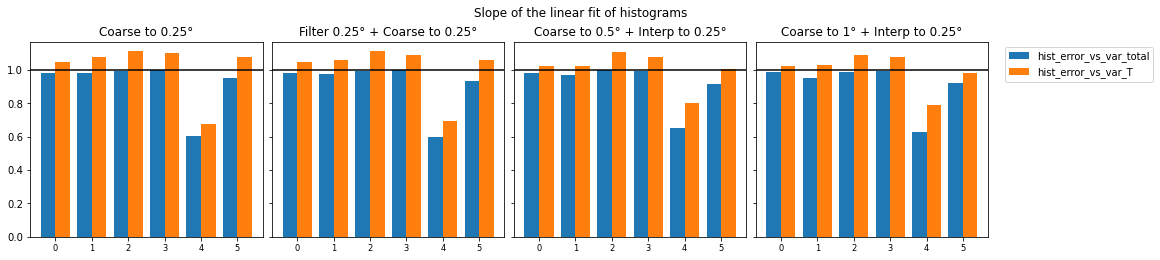

In [47]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 3.5), sharey=True)
fig.suptitle(r'Slope of the linear fit of histograms')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['hist_error_vs_var_total', 'hist_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [hists[region]['HR_Filtered'][ifilter][quantity].attrs['slope'] for region in range(len(data))], width=bar_width, label=quantity)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

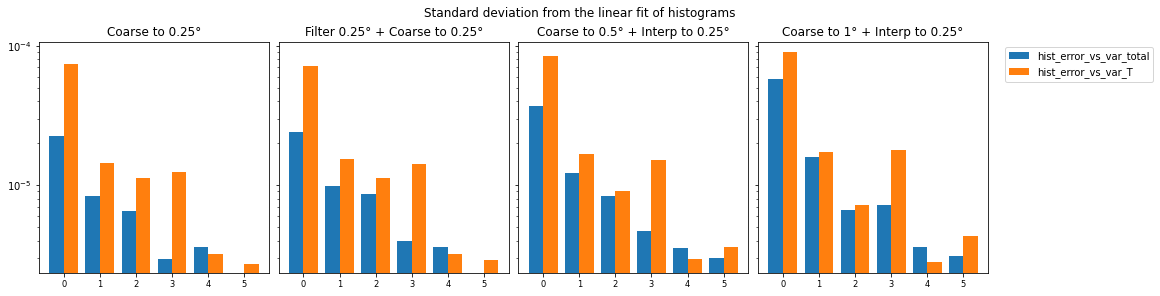

In [48]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Standard deviation from the linear fit of histograms')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['hist_error_vs_var_total', 'hist_error_vs_var_T']) :
        ax[ifilter].bar(x+iq*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][quantity].attrs['residuals']) for region in range(len(data))], width=bar_width, label=quantity)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    #axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
plt.show()

Observations :
- Fortunately, fitting the histograms gives similar slope more or less independently of the filtering/coarsening scheme. 
- Different regions and seasons show almost the same slope, except Westmed, especially winter (?). This could indicate that in this region there could be other contributions to the density error (could be presence of boundaries + contribution of "badly" averaged 1st derivative in Taylor expansion, or contribution of higher order terms)
- The "only-temperature" variance gives in general slightly larger slope and larger standard deviation (the points are more scattered on the histogram). 
- The standard deviation and the spread of the points on the histograms increases when coarsening to lower resolutions, meaning that the approximation works worse.

Main conclusion: overall, the assumption that the density error is mainly determined by the subrid variances appears to be valid and works relatitely well in different regions and under different filters. Most of the density error (more than 90%) comes from the temperature subgrid variance term.   

# 2nd assumption: link between the true subgrid variance and its parametrization through spatial derivatives

Proposed parametrization links the subgrid temperature variance with its spatial gradient (or more precisely, finite-difference approximation of the gradient):

$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \overline{T}|^2 $$ 
where 
$$ |\delta \textbf{x} \cdot \nabla \overline{T}|^2 (x,y) \equiv \frac{1}{4} \left[\overline{T}(x+\Delta x, y) - \overline{T}(x - \Delta x, y)\right]^2 + \frac{1}{4}\left[\overline{T}(x, y+\Delta y) - \overline{T}(x, y- \Delta y)\right]^2 $$
and the same for salinity.

In [49]:
# def diffs_x(dataArray) :
#     return (dataArray.shift(x=-1) - dataArray)
# def diffs_y(dataArray) :
#     return (dataArray.shift(y=-1) - dataArray)
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [50]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_T_sqr"] = central_diffs_x(ds['sosstsst'])**2 + central_diffs_y(ds['sosstsst'])**2
        ds["diff_S_sqr"] = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2

CPU times: user 2.22 s, sys: 15.4 ms, total: 2.24 s
Wall time: 2.23 s


## Plot surface snapshots of subgrid variance

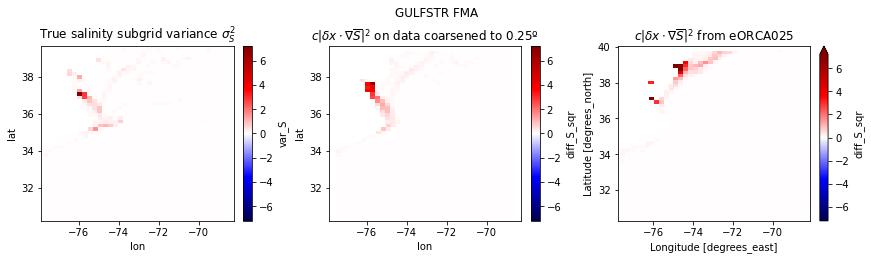

In [51]:
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3.5))
region = 0
ifilter = 0
fig.suptitle(data[region]['label'])
cmap = 'seismic'

plot0 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['var_S'][bord_cut].plot(x='lon', y='lat', ax=ax[0], cmap=cmap)
ax[0].set(title=r'True salinity subgrid variance $\sigma_S^2$')

plot1 =(0.2*data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['diff_S_sqr'][bord_cut]).plot(x='lon', y='lat', ax=ax[1], \
                                                                                                        cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[1].set(title=r'$c|\delta {x} \cdot \nabla \overline{S}|^2$ on data coarsened to 0.25º')
plot1.colorbar = plot0.colorbar

data[region]['LR'].isel(time_counter=-1)['diff_S_sqr'][bord_cut].plot(x='lon', y='lat', ax=ax[2], cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[2].set(title=r'$c|\delta {x} \cdot \nabla \overline{S}|^2$ from eORCA025')
plt.show()

## Spatial covariance between the true subgrid variance and the squares of gradients

Spatial correlation coefficient $R$ between the 'true' subgrid temperature variance $\sigma_T^2$ and the squared finite differences $|\delta \textbf{x} \cdot \nabla \bar{T}|^2$ (for temperature and salinity)

In [52]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'] = xr.corr(data[i]['HR_Filtered'][ifilter]['diff_T_sqr'], data[i]['HR_Filtered'][ifilter]['var_T'], \
                                                                          dim=['x', 'y']).compute()
        hists[i]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'] = xr.corr(data[i]['HR_Filtered'][ifilter]['diff_S_sqr'], data[i]['HR_Filtered'][ifilter]['var_S'], \
                                                                          dim=['x', 'y']).compute()

CPU times: user 5.28 s, sys: 124 ms, total: 5.41 s
Wall time: 16.7 s


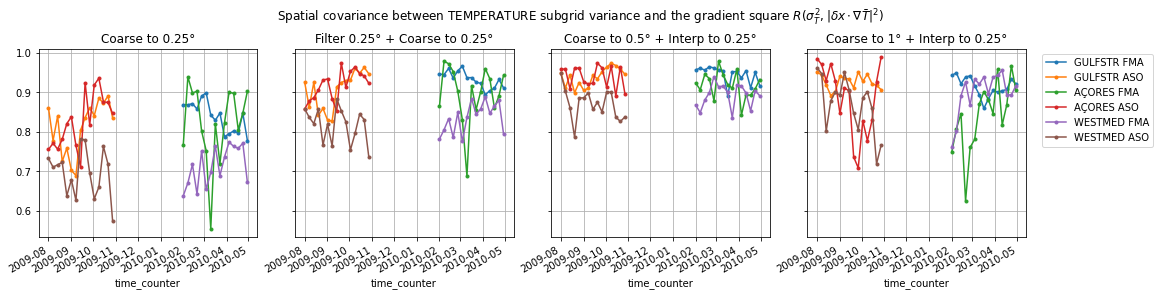

In [53]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between TEMPERATURE subgrid variance and the gradient square $R(\sigma_T^2, |\delta {x} \cdot \nabla \bar{T}|^2)$')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

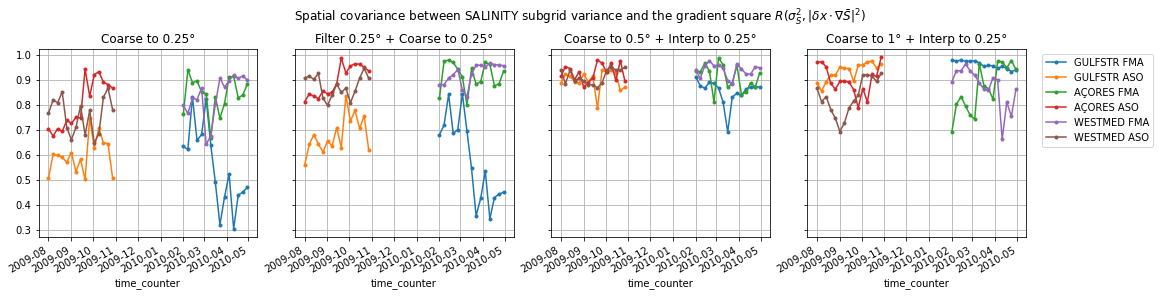

In [54]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between SALINITY subgrid variance and the gradient square $R(\sigma_S^2, |\delta {x} \cdot \nabla \bar{S}|^2)$')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

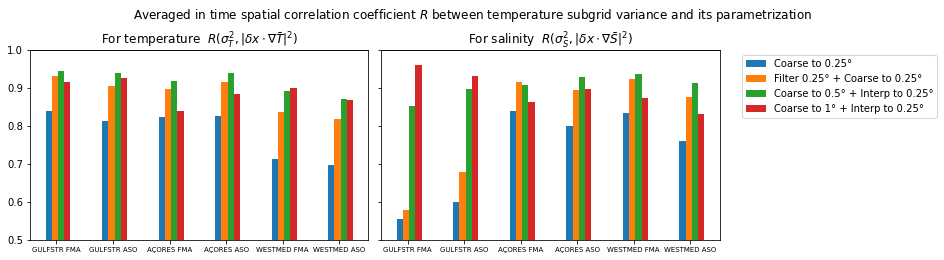

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(13, 3.5), sharey=True)
fig.suptitle(r'Averaged in time spatial correlation coefficient $R$ between temperature subgrid variance and its parametrization')
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter]['corr_var_T_vs_diff_T_sqr'].mean() for region in range(len(data))], width=bar_width,\
          label=filters[ifilter]['label'])
    ax[1].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter]['corr_var_S_vs_diff_S_sqr'].mean() for region in range(len(data))], width=bar_width,\
          label=filters[ifilter]['label'])
ax[0].set(title=r'For temperature  $R(\sigma_T^2, |\delta {x} \cdot \nabla \bar{T}|^2)$')
ax[1].set(title=r'For salinity  $R(\sigma_S^2, |\delta {x} \cdot \nabla \bar{S}|^2)$')
for axis in ax: 
    axis.axhline(y=1., color='k')
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=7)
    axis.set(yscale='linear')
    axis.set_ylim(0.5, 1.)

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Observations: 
- Spatial correlation coefficient appears to be different for different filtering schemes.
- For example, adding filtering before coarsening ro 0.25deg (orange bars) improves spatial correlation between the 'true' subgrid variance and the proposed parametrization, especially for the temperature. Surprisingly, coarsening to lower resolution alreas improves spatial covariance (?)
- Correlation coefficient varies with regions, especially strongly for salinity. Something is really wrong with salinity gradients/variance in Gulf Stream, apparently the problem in the vicinity of the boundaries: the points at the corders contaminate the box-average (try masking out the border regions for stats ???).
- Overall, the results show clear dependence of the accuracy of the parametrization on the choice of the filtering scheme. Which is expected, since filtering/coarsening operations influence a lot spatial numerical derivatives.

## 2D histograms of true subgrid variance of temperature and salinity and its parametrization

In [56]:
%%time
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 2.68 s, sys: 68.9 ms, total: 2.75 s
Wall time: 9.38 s


In [57]:
%%time
name_hist = 'hist_var_S'
x = 'diff_S_sqr'
y = 'var_S'
for i in range(len(data)) :
    # reference histogram
    ref_case = 2
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 2.74 s, sys: 82.4 ms, total: 2.82 s
Wall time: 8.96 s


### Temperature

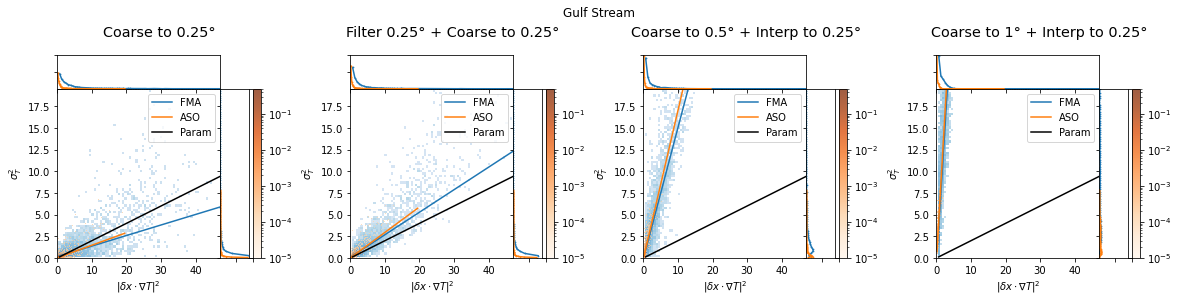

In [58]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla T|^2$', ylabel=r'$\sigma_T^2$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

### Salinity

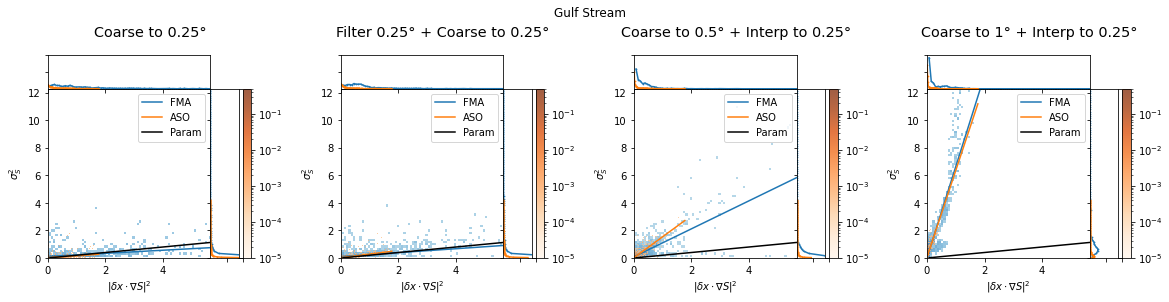

In [59]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_var_S'
x = 'diff_S_sqr'
y = 'var_S'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla S|^2$', ylabel=r'$\sigma_S^2$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

Observations:
- Clearly, filtering/coarsening scheme change a lot the histograms of 2D distributions of the subgrid variance vs. its parametrization.
- When coarsening onto lower resolution grids, we smooth more the fields and therefore suppress the strong gradients, so the points of histograms are all concentrated at relatively low gradients. At the same time, the subgrid variance increases in general, since there is more and more statistical variance that is cut by the filter and goes to the subgrid side. It can be clearly see from the last plot with the most coarened data: the gradients are small, but the subgrid variance is present for a significant number of points, which makes the histogram look almost vertical. If we coarse on a lower resolution grid, it will become even more vertical.
- Coefficient $c$ is proportional to the filtering parameter (relation between the grid sizes)


## Linear fit of histograms

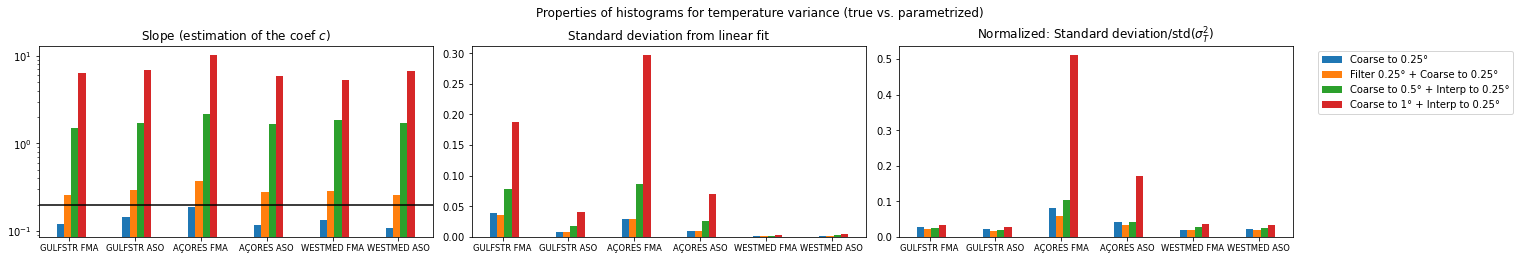

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance (true vs. parametrized)')
name_hist = 'hist_var_T'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of the coef $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

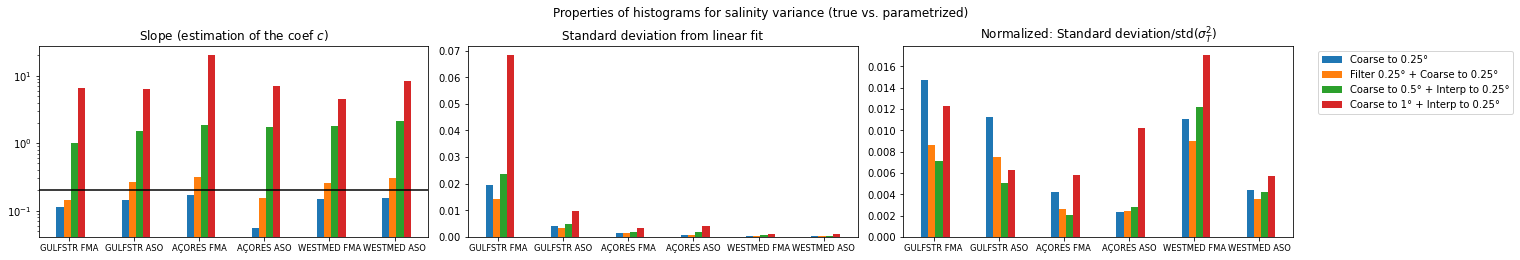

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for salinity variance (true vs. parametrized)')
name_hist = 'hist_var_S'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of the coef $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Estimation of the coefficient c in the parametrization

In [62]:
for ifilter in range(len(filters)) :
    filters[ifilter]['coef_T'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_var_T'].attrs['slope'] for i in range(len(data))])
    filters[ifilter]['coef_S'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_var_S'].attrs['slope'] for i in range(len(data))])

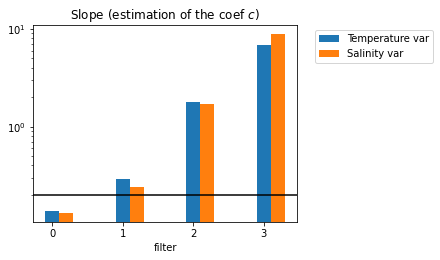

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6, 3.5))
x = np.arange(4)
bar_width = 0.2
ax.bar(x, [filters[ifilter]['coef_T'] for ifilter in [0,1,2,3]], width=bar_width, label='Temperature var')
ax.bar(x+bar_width, [filters[ifilter]['coef_S'] for ifilter in [0,1,2,3]], width=bar_width, label='Salinity var')
ax.set_xticks(x)
#ax.set_xticklabels([filters[ifilter]['label'] for ifilter in range(len(filters))],fontsize=6)
ax.axhline(y=0.2, color='k')
ax.set(xlabel='filter', title=r'Slope (estimation of the coef $c$)')
ax.set(yscale='log')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Observations:
- The choice of the adjustable parameter $c$ in the deterministic parametrization for the temperature subgrid variance depends strongly on the chosen averaging procedure.
- The value of $c=0.2$ proposed in the paper (horizontal black line on the plots) lies somewhere in between slopes obtained coarsed only and filtered+coarsed data sets.
- The coefficicents for temperature and salinity variances are not exactly the same.  

# Predictors for density correction

Summing up two assumptions discussed above, here we will focus on the predictors for the the density error, which are:

$$ P_T \equiv \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} |\delta \textbf{x} \cdot \nabla \overline{T}|^2 $$
$$ P_S \equiv \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{S}^2} |\delta \textbf{x} \cdot \nabla \overline{S}|^2 $$
$$ P_{TS} \equiv \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T} \partial \bar{S}} |\delta \textbf{x} \cdot \nabla \overline{S}| |\delta \textbf{x} \cdot \nabla \overline{T}| $$
And their sum:
$$ P_{total} \equiv P_T + P_{TS} + P_S $$
Then, the density error according to the proposed parametrization is:
$$  \rho_c \approx c P_{total} \quad \text{or} \quad \rho_c \approx c P_T  $$
where the constant $c$ comes from the parametrization of the subgrid variances. </br>
Note that these quantities are evaluated with the use of the filtered fields only (there is no information needed about the subgrid quantities).

Compute the predictors:

In [64]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["predictor_T"] = 0.5*ds['rho_ct_ct']*ds["diff_T_sqr"]
        ds["predictor_S"] = 0.5*ds['rho_sa_sa']*ds["diff_S_sqr"]
        ds["predictor_TS"] = ds['rho_sa_ct']*np.sqrt(ds["diff_T_sqr"])*np.sqrt(ds["diff_S_sqr"])
        ds["predictor_total"] = ds["predictor_T"] + ds["predictor_TS"] + ds["predictor_S"]

CPU times: user 1.22 s, sys: 8.11 ms, total: 1.23 s
Wall time: 1.22 s


Compute some stats for the predictors (mean, std):

In [65]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        for quantity in ["predictor_T", "predictor_S", "predictor_TS", "predictor_total"] :
            ds.attrs['mean_' + quantity] = ds[quantity].mean().compute()
            ds.attrs['std_' + quantity] = ds[quantity].std().compute()
            ds['normalized_'+quantity] = ((ds[quantity]-ds.attrs['mean_' + quantity])/ds.attrs['std_' + quantity]).compute()

CPU times: user 28.8 s, sys: 545 ms, total: 29.4 s
Wall time: 1min 25s


In [66]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))]:
        for quantity in ["sigma0_delta"] :
            ds.attrs['mean_' + quantity] = ds[quantity].mean().compute()
            ds.attrs['std_' + quantity] = ds[quantity].std().compute()
            ds['normalized_'+quantity] = ((ds[quantity]-ds.attrs['mean_' + quantity])/ds.attrs['std_' + quantity]).compute()

CPU times: user 1.12 s, sys: 77.5 ms, total: 1.2 s
Wall time: 5.47 s


## Contribution of each term

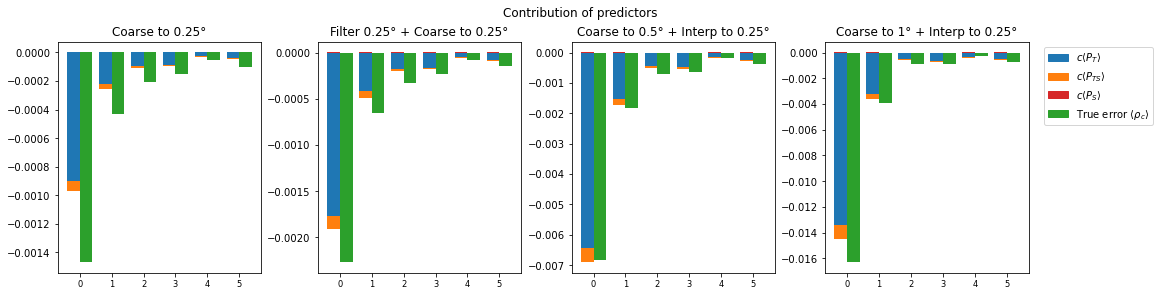

In [124]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=False)
fig.suptitle(r'Contribution of predictors')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    coef = filters[ifilter]['coef_T']
    for i in range(len(data)) :
        ds = data[i]['HR_Filtered'][ifilter]
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_T'], width=bar_width, color=line_colors[0])
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_TS'], bottom=coef*ds.attrs['mean_predictor_T'], width=bar_width, color=line_colors[1])
        ax[ifilter].bar(x[i], coef*ds.attrs['mean_predictor_S'], width=bar_width, color=line_colors[3])
        ax[ifilter].bar(x[i]+bar_width, ds.attrs['mean_sigma0_delta'], width=bar_width, color=line_colors[2])
    ax[ifilter].set(title=filters[ifilter]['label'])
patches = [None]*4
patches[0] = mpatches.Patch(color=line_colors[0], label=r'$c \langle P_T \rangle$')
patches[1] = mpatches.Patch(color=line_colors[1], label=r'$c \langle P_{TS} \rangle$')
patches[2] = mpatches.Patch(color=line_colors[3], label=r'$c \langle  P_S \rangle$')
patches[3] = mpatches.Patch(color=line_colors[2], label=r'True error $\langle \rho_c \rangle$')
ax[-1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    #axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear')
plt.show()

- In average, the proposed parametrization tends to slightly underestimate the density error (when looking at the averaged values). 
- Coefficient $c$ can be probably better adjusted and be individual for each predictor

## 1D Histograms of predictors

In [68]:
%%time
normalized = False
for quantity in ["predictor_T", "predictor_S", "predictor_TS", "predictor_total"] :
    if normalized :
        variable = 'normalized_'+quantity
    else :
        variable = quantity
    for i in range(len(data)) :
        # reference histogram (to make same bins for all histograms - better for comparison)
        ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_histo[variable+'_bin'].values

        hists[i]['LR'][variable] = compute_1D_histogram(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()
        for ifilter in range(len(filters)) :
            hists[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], variable, nb_of_bins, bins=ref_bins)

CPU times: user 13.9 s, sys: 253 ms, total: 14.1 s
Wall time: 36.5 s


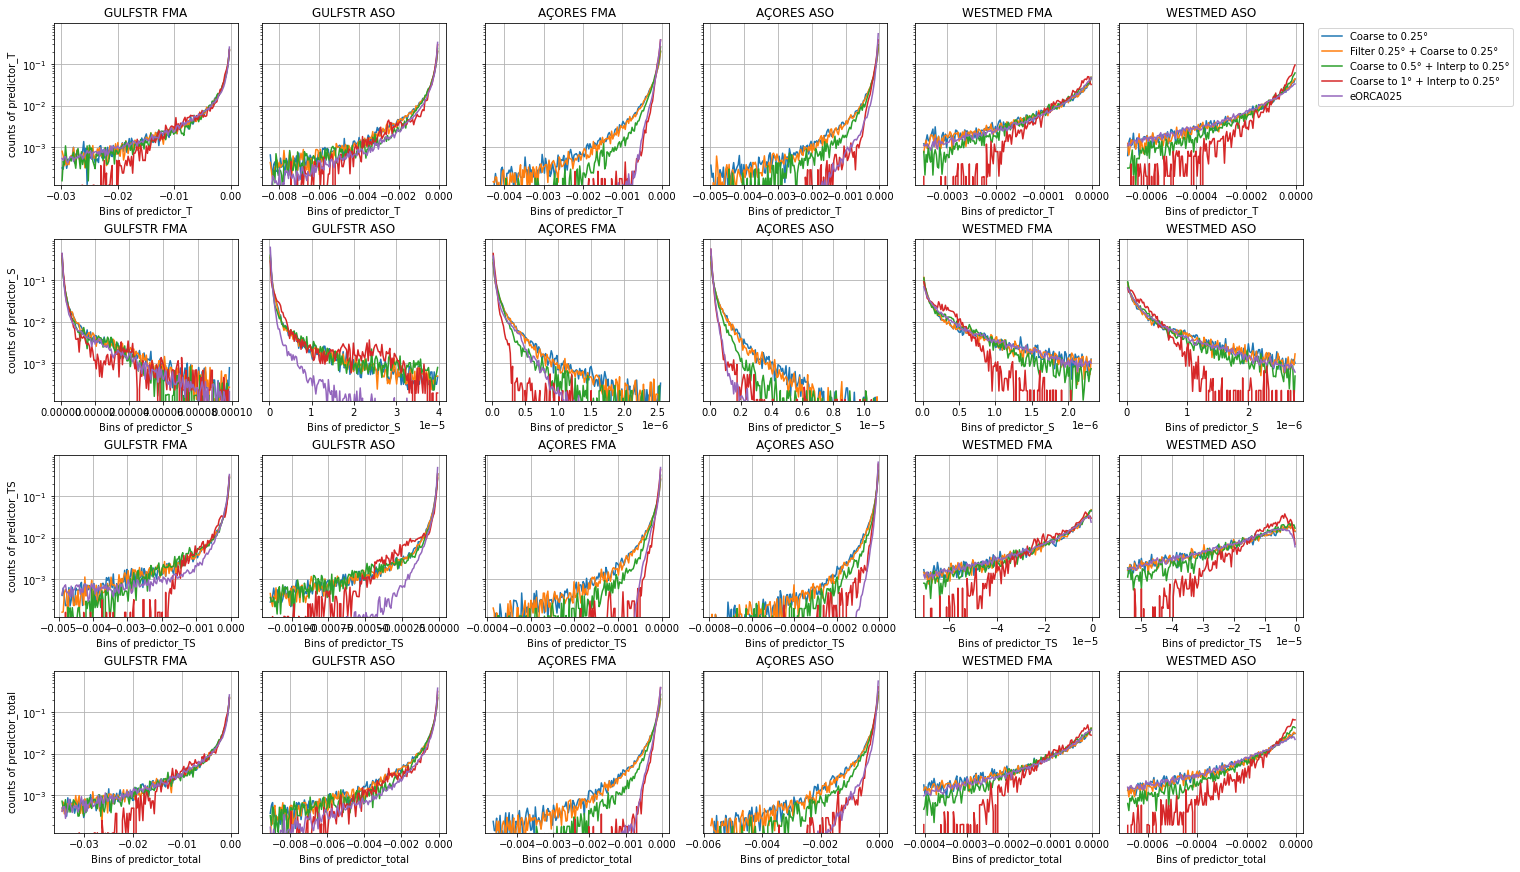

In [69]:
fig, ax = plt.subplots(nrows=4, ncols=len(data), constrained_layout=True, figsize=(3.5*len(data), 3*4), sharey=True)
for row, quantity in enumerate(["predictor_T", "predictor_S", "predictor_TS", "predictor_total"]) :
    for i in range(len(data)) :
        for ifilter in range(len(filters)) :
            ds = hists[i]['HR_Filtered'][ifilter]
            ds[quantity].plot(ax=ax[row,i], label=ds['label'], color=line_colors[ifilter])
        hists[i]['LR'][quantity].plot(ax=ax[row,i], label=hists[i]['LR']['label'], color=line_colors[len(filters)])
        ax[row,i].set(title=data[i]['label'], yscale='log', ylabel='', xlabel=r'Bins of '+quantity); ax[row,i].grid(True)
    ax[row,0].set(ylabel='counts of '+quantity)
ax[0,-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- From 1d Histograms for the density error one can see that in winter Gulf Stream and West Med the filtered/coasened HR data visually has very similar distributions.
- The most obvious difference appears in salinity of Gulf Stream in summer and in Acores data. In all cases, the eORCA025 data does not contain strong gradient points, which exist in eNATL60 data and persist even afer coarse-graining. 
- The discrepancy in Acores is determined by the occurence of some unlocal structures having strong gradients relative to the background flow. The size of these structures is clearly larger than the grid resolution of eORCA025.
- The low-resolution data from eORCA025 does not demonstrate presence of such structures, at least on the selected time span. Probably, even if they are resolved in LR simulation, they get dissipated before reaching the considered region, unlikely to eNATL60 simulations, where they can survive longer and be transported farther. 

## 2D Histograms of true density error vs. predictor T

In [71]:
%%time
name_hist = 'hist_delta_sigma'
x = 'predictor_T'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 3
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 4.05 s, sys: 87 ms, total: 4.14 s
Wall time: 10.8 s


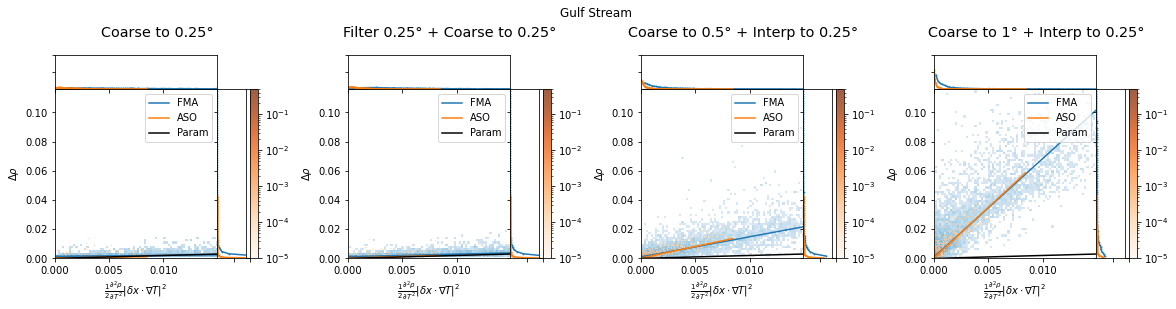

In [72]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_delta_sigma'
x = 'predictor_T'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$\frac{1}{2} \frac{\partial^2 \rho}{\partial T^2}|\delta x \cdot \nabla T|^2$', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

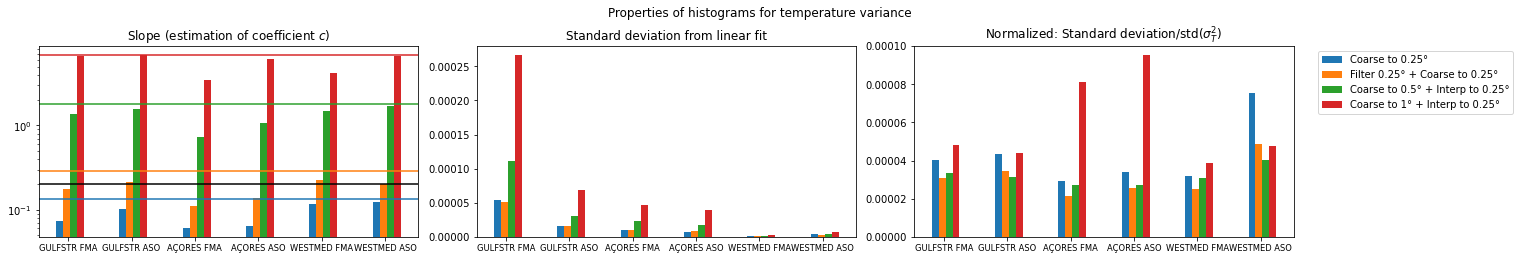

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance')
name_hist = 'hist_delta_sigma'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[0].axhline(y=filters[ifilter]['coef_T'], color=line_colors[ifilter])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of coefficient $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- The color horizontal lines correspond to the coefficients of the parametrization for temperature variance, considered above.
- The parametrization coefficicnet $c$ evaluated on the basis of the averaged predictors (based on the temperature variance approximated with finite differences) and the true density error gives is lower comparing to the coefficicent evaluated through the true subgrid variance.
- The differene in two evaluations comes most likely from neglecting the mixed-variance term in the last case. 

## 2D Histograms of true density error vs. total predictor

In [84]:
%%time
name_hist = 'hist_delta_sigma_total'
x = 'predictor_total'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 3
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case][bord_cut], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 6.16 s, sys: 96.2 ms, total: 6.26 s
Wall time: 14.4 s


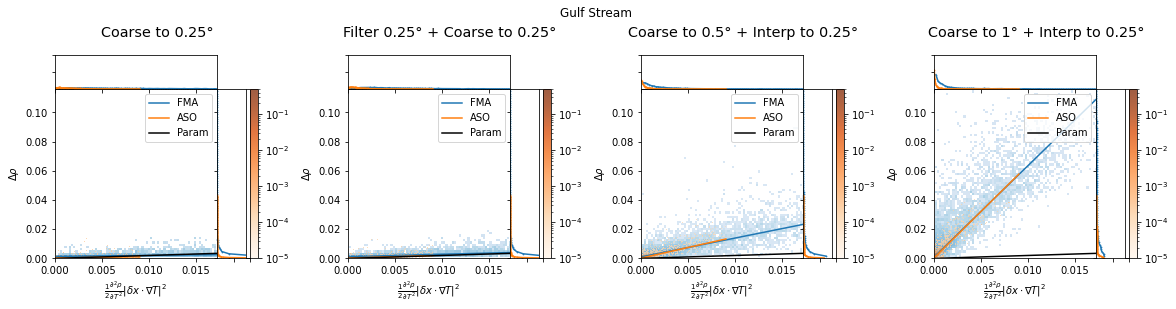

In [85]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_delta_sigma_total'
x = 'predictor_total'
y = 'sigma0_delta'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.2*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$\frac{1}{2} \frac{\partial^2 \rho}{\partial T^2}|\delta x \cdot \nabla T|^2$', ylabel=r'$\Delta \rho$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

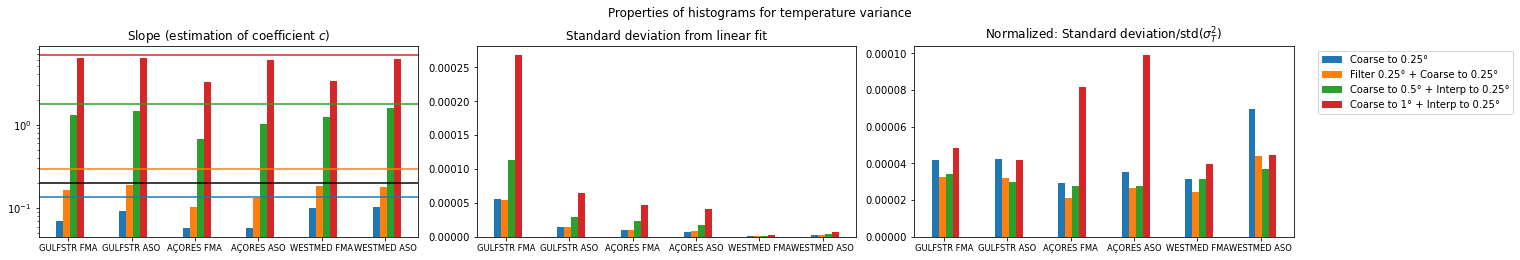

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance')
name_hist = 'hist_delta_sigma_total'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'][bord_cut].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[0].axhline(y=filters[ifilter]['coef_T'], color=line_colors[ifilter])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title=r'Slope (estimation of coefficient $c$)')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Comparison (only temperature vs. all terms)

### Spatial covariance between true error and predictors

In [98]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)):
        hists[i]['HR_Filtered'][ifilter]['corr_true_delta_vs_predictor_T'] = xr.corr(data[i]['HR_Filtered'][ifilter]['predictor_T'], \
                                                                                     data[i]['HR_Filtered'][ifilter]['sigma0_delta'], dim=['x', 'y']).compute()
        hists[i]['HR_Filtered'][ifilter]['corr_true_delta_vs_predictor_total'] = xr.corr(data[i]['HR_Filtered'][ifilter]['predictor_total'], \
                                                                                     data[i]['HR_Filtered'][ifilter]['sigma0_delta'], dim=['x', 'y']).compute()

CPU times: user 11 s, sys: 152 ms, total: 11.1 s
Wall time: 26.9 s


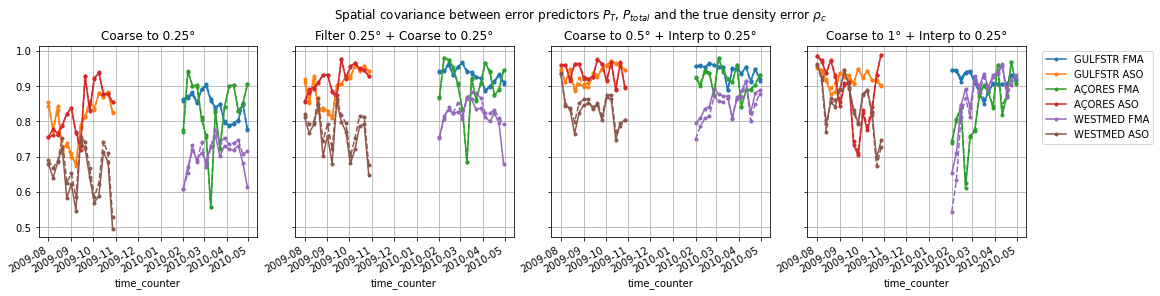

In [100]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True) 
fig.suptitle(r'Spatial covariance between error predictors $P_T$, $P_{total}$ and the true density error $\rho_c$')
for ifilter in range(len(filters)):
    for i in range(len(data)) :
        hists[i]['HR_Filtered'][ifilter]['corr_true_delta_vs_predictor_T'].plot(ax=ax[ifilter], ls='-', marker='.', label=data[i]['label'], color=line_colors[i])
        hists[i]['HR_Filtered'][ifilter]['corr_true_delta_vs_predictor_total'].plot(ax=ax[ifilter], ls='--', marker='.', color=line_colors[i])
    ax[ifilter].set(title=filters[ifilter]['label']); ax[ifilter].grid(True)    
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Dashed lines - total predictor, continious lines - temperature-only 

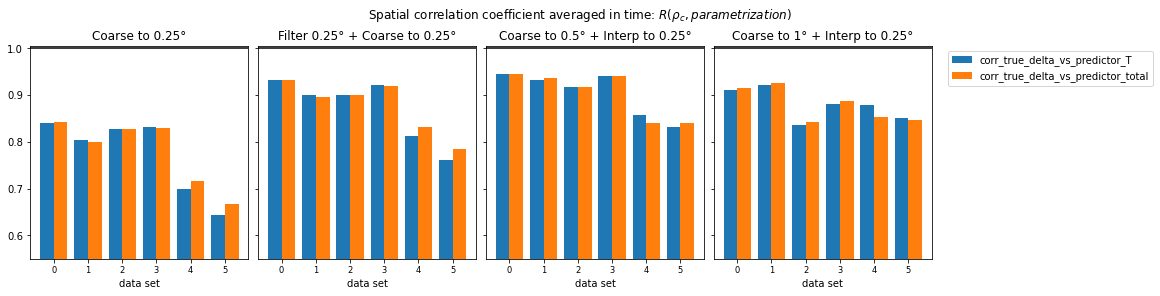

In [104]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4), sharey=True)
fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(6)
bar_width = 0.4
for ifilter in range(len(filters)) :
    for iq, quantity in enumerate(['corr_true_delta_vs_predictor_T', 'corr_true_delta_vs_predictor_total']) :
        ax[ifilter].bar(x+iq*bar_width, [(hists[region]['HR_Filtered'][ifilter][quantity].mean()) for region in range(len(data))], width=bar_width, label=quantity)
    ax[ifilter].set(title=filters[ifilter]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax :
    axis.set_xticks(x + 0.5*bar_width)
    axis.axhline(y=1., color='k')
    #axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.set_xticklabels([region for region in range(len(data))],fontsize=10)
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='linear', ylim=[0.55,1.005])
plt.show()

- The correlation coefficient between the true density error and the predictor depends on the filter choice. 
- Pure coarsening to 0.25deg gives the weakest correlation coefficient among all filtering schemes (?)
- When comparing the correlation coefficient, the difference between using the tempreture-only predictor and the total one is not very strong.

### Coefficient c

Computed as an average between the regions and seasons:

In [87]:
for ifilter in range(len(filters)) :
    filters[ifilter]['coef_dens_total'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_delta_sigma_total'].attrs['slope'] for i in range(len(data))])
    filters[ifilter]['coef_dens_T'] = np.mean([hists[i]['HR_Filtered'][ifilter]['hist_delta_sigma'].attrs['slope'] for i in range(len(data))])

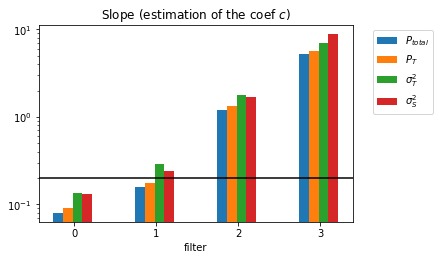

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6, 3.5))
x = np.arange(4)
bar_width = 0.12
ax.bar(x, [filters[ifilter]['coef_dens_total'] for ifilter in [0,1,2,3]], width=bar_width, label=r'$P_{total}$')
ax.bar(x+bar_width, [filters[ifilter]['coef_dens_T'] for ifilter in [0,1,2,3]], width=bar_width, label=r'$P_T$')
ax.bar(x+2*bar_width, [filters[ifilter]['coef_T'] for ifilter in [0,1,2,3]], width=bar_width, label=r'$\sigma^2_T$')
ax.bar(x+3*bar_width, [filters[ifilter]['coef_S'] for ifilter in [0,1,2,3]], width=bar_width, label=r'$\sigma^2_S$')
ax.set_xticks(x+0.2)
ax.set_xticklabels([ifilter for ifilter in range(len(filters))])
ax.axhline(y=0.2, color='k')
ax.set(xlabel='filter', title=r'Slope (estimation of the coef $c$)')
ax.set(yscale='log')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Applying density parametrization to eORCA025 and filtered data

From (Stanley et al 2021), the density correction is determined mainly by the temperature subgrid variance $\sigma^2_T$ and the local second derivative of the density with the respect to temperature (known from the EOS) evaluated on the basis of filtered fields.
It is proposed to estimate the temperature subgrid variance with local gradient (computed numerically through finite differences):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$ for the central finite differene scheme.

Here, we take the coefficients $c$ that were VERY APPROXIMATELY estimated above from fitting the scattered points on 2D histograms. In the current version, the coefficient $c$ estimated from the histograms of the true density error vs. the predictor $P_T$ is taken.

The parametrization in application to the eORCA025 data is tested with 4 different coefficients $c$ obtained for different filters

In [162]:
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        data[i]['HR_Filtered'][ifilter]['param_sigma0_delta'] = filters[ifilter]['coef_dens_T']*data[i]['HR_Filtered'][ifilter]["predictor_T"]
        data[i]['LR']['param_sigma0_delta_filter'+str(ifilter)] = filters[ifilter]['coef_dens_T']*data[i]['LR']["predictor_T"]

## Plot snapshots of density error parametrization

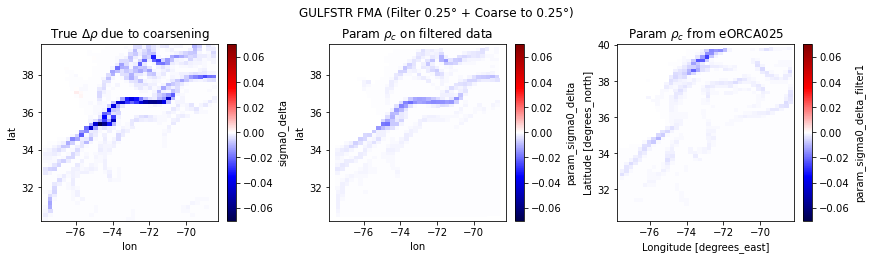

In [165]:
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 3.5))
region = 0
ifilter = 1
fig.suptitle(data[region]['label'] + ' (' + filters[ifilter]['label'] + ')')
cmap = 'seismic'

plot0 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['sigma0_delta'][bord_cut].plot(x='lon', y='lat', ax=ax[0], cmap=cmap)
ax[0].set(title=r'True $\Delta \rho$ due to coarsening')

plot1 = data[region]['HR_Filtered'][ifilter].isel(time_counter=-1)['param_sigma0_delta'][bord_cut].plot(x='lon', y='lat', ax=ax[1], \
                                                                                                        cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[1].set(title=r'Param $\rho_c$ on filtered data')
plot1.colorbar = plot0.colorbar

data[region]['LR'].isel(time_counter=-1)['param_sigma0_delta_filter'+str(ifilter)][bord_cut].plot(x='lon', y='lat', ax=ax[2], cmap=cmap, vmin=plot0.colorbar.vmin, vmax=plot0.colorbar.vmax)
ax[2].set(title=r'Param $\rho_c$ from eORCA025')
plt.show()

## 1D Histograms

In [166]:
%%time
for i in range(len(data)) :
    # reference histogram
    ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3][bord_cut], 'param_sigma0_delta', nb_of_bins, bins=None).compute()
    ref_bins = ref_histo['param_sigma0_delta_bin'].values

    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter]['param_sigma0_delta'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], 'param_sigma0_delta', nb_of_bins, bins=ref_bins)
        hists[i]['HR_Filtered'][ifilter]['sigma0_delta'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], 'sigma0_delta', nb_of_bins, bins=ref_bins)
        hists[i]['LR']['param_sigma0_delta_filter'+str(ifilter)] = compute_1D_histogram(data[i]['LR'][bord_cut], 'param_sigma0_delta_filter'+str(ifilter), nb_of_bins, bins=ref_bins).compute()

CPU times: user 7.26 s, sys: 117 ms, total: 7.38 s
Wall time: 20.3 s


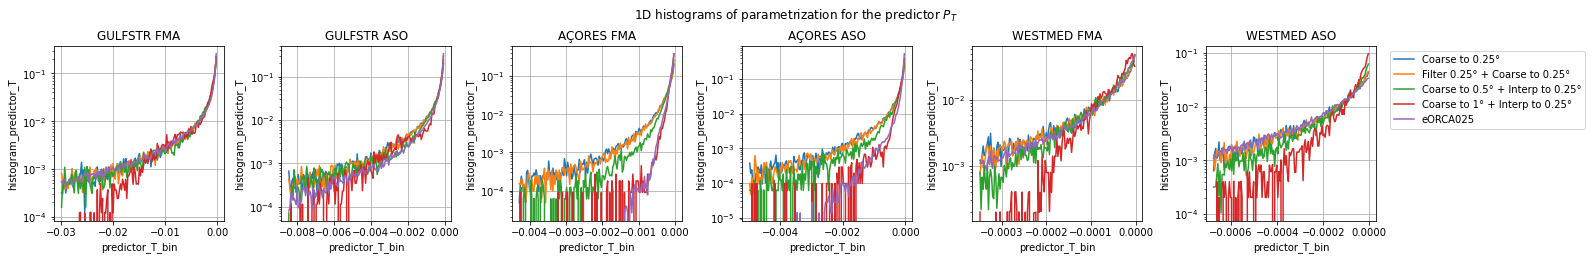

In [167]:
fig, ax = plt.subplots(nrows=1, ncols=6, constrained_layout=True, figsize=(22, 3.5))
fig.suptitle(r'1D histograms of parametrization for the predictor $P_T$')
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        ds = hists[i]['HR_Filtered'][ifilter]
        ds['predictor_T'].plot(ax=ax[i], label=ds['label'], color=line_colors[ifilter])
    hists[i]['LR']['predictor_T'].plot(ax=ax[i], label=hists[i]['LR']['label'], color=line_colors[len(filters)])
    ax[i].set(title=data[i]['label'], yscale='log'); ax[i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

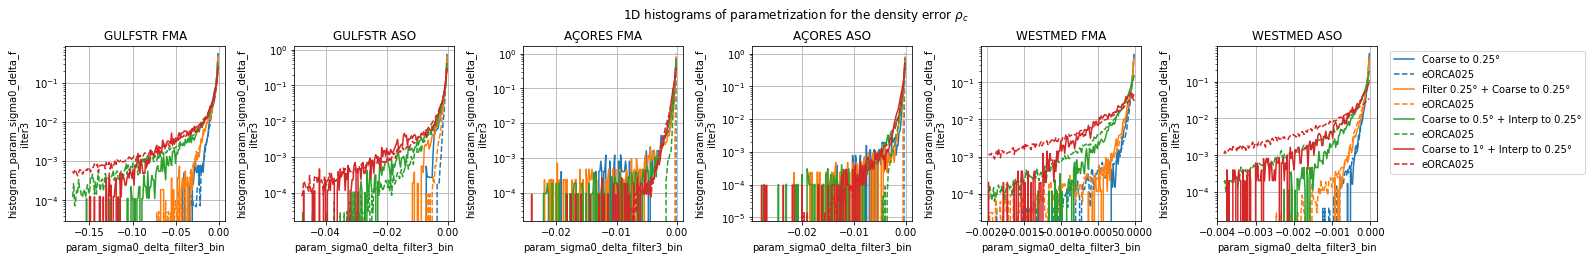

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=6, constrained_layout=True, figsize=(22, 3.5))
fig.suptitle(r'1D histograms of parametrization for the density error $\rho_c$')
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        ds = hists[i]['HR_Filtered'][ifilter]
        ds['param_sigma0_delta'].plot(ax=ax[i], label=ds['label'], color=line_colors[ifilter])
        #ds['sigma0_delta'].plot(ax=ax[i], ls='--')
        hists[i]['LR']['param_sigma0_delta_filter'+str(ifilter)].plot(ax=ax[i], label=hists[i]['LR']['label'], ls='--', color=line_colors[ifilter])
    ax[i].set(title=data[i]['label'], yscale='log'); ax[i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [146]:
# %%time
# fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15, 6))
# fig.suptitle(r'Mean and starndard deviation')
# x = np.arange(len(data))
# bar_width = 0.11

# for col, quantity in enumerate(['predictor_T', 'predictor_S']) :
#     for row, stat_mom in enumerate(['mean', 'std']) :
#         for ifilter in range(len(filters)) :
#             ax[row,col].bar(x+(ifilter)*bar_width, [data[region]['HR_Filtered'][ifilter].attrs[stat_mom+'_'+quantity] for region in range(len(data))], width=bar_width, \
#                       label=filters[ifilter]['label'])
#         ax[row,col].bar(x+4*bar_width, [data[region]['LR'].attrs[stat_mom+'_'+quantity] for region in range(len(data))], width=bar_width, label='eORCA025')
#         ax[row,col].set_xticks(x + 1.25*bar_width)
#         ax[row,col].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
#         ax[row,col].xaxis.set_tick_params(labelsize='small')
#         ax[row,col].set(yscale='linear')
#         ax[row,col].set(title=stat_mom+'_'+quantity)
# ax[0,0].set(title=r'Mean $P_T$')
# ax[1,0].set(title=r'STD $P_T$')
# ax[0,1].set(title=r'Mean $P_S$')
# ax[1,1].set(title=r'STD $P_S$')
# ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

## Distance betweeen histograms

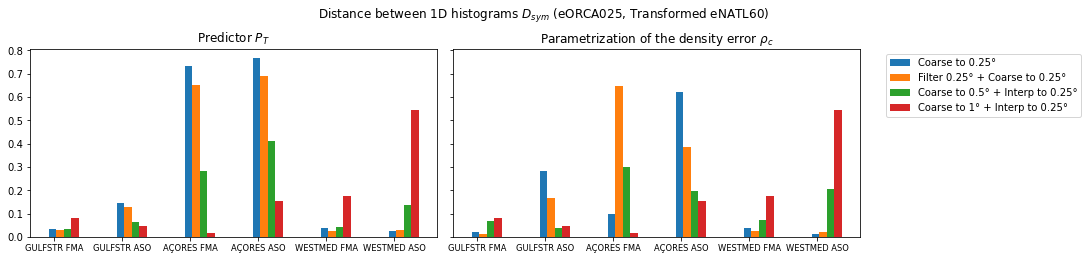

In [181]:
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5), sharey=True)
fig.suptitle('Distance between 1D histograms $D_{sym}$ (eORCA025, Transformed eNATL60)')
x = np.arange(len(data))
bar_width = 0.11
for ifilter in range(len(filters)) :
    axis[0].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region]['LR']['predictor_T'], hists[region]['HR_Filtered'][ifilter]['predictor_T']) \
                                          for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    axis[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region]['LR']['param_sigma0_delta_filter'+str(ifilter)], hists[region]['HR_Filtered'][ifilter]['param_sigma0_delta']) \
                                          for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for ax in axis :
    ax.set_xticks(x + 1.25*bar_width)
    ax.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    ax.xaxis.set_tick_params(labelsize='small')
    ax.set(yscale='linear')
axis[0].set(title=r'Predictor $P_T$')
axis[1].set(title=r'Parametrization of the density error $\rho_c$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()